In [2]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20181217

@author: zhangji
"""

%pylab inline
pylab.rcParams['figure.figsize'] = (25, 11)
fontsize = 40

import os
import glob
import numpy as np
import scipy as sp
import scipy.misc
import pandas as pd
import re
from scanf import scanf
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from sympy import symbols, simplify, series, exp
from sympy.matrices import Matrix
from sympy.solvers import solve
from scipy.optimize import leastsq, curve_fit
from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
from IPython.display import display, HTML
from scipy import interpolate
from codeStore import support_fun as spf
from matplotlib import animation, rc
from tqdm import tqdm_notebook as tqdm
import natsort 
from shutil import copyfile

rc('animation', html='html5')
PWD = os.getcwd()
font = {'size': 20}
matplotlib.rc('font', **font)
np.set_printoptions(linewidth=90, precision=5)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])
    
def update_lines(num, ecoli_nodes_list, line_list):
    for line in line_list:
        line.set_data([], [])
        line.set_3d_properties([])
    line = line_list[num]
    ecoli_nodes = ecoli_nodes_list[num]
    line.set_data(ecoli_nodes[:, 0:2].T)
    line.set_3d_properties(ecoli_nodes[:, 2])
    return line

def save_motion_ecoli_mp4(dir_name, file_handle, fig=None, ax=None):
    print(dir_name, file_handle)
    t_dir = os.path.join(PWD, dir_name + file_handle)
    mat_names = glob.glob('%s/%s_*.mat' % (t_dir, file_handle))
    
    if fig is None:
        fig = plt.figure(figsize=(20, 15))
        fig.patch.set_facecolor('white')
        ax = axes3d.Axes3D(fig)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=25, bitrate=1800, metadata=dict(artist='ZhangJi', title=file_handle, copyright='MIT'))

    line_list = []
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_u_list = []
    ecoli_f_list = []
    mat_names = natsort.natsorted(mat_names)
#     mat_names = mat_names[:10] + mat_names[-10:]
    for mati in mat_names:
        mat_contents = loadmat(mati)
        ecoli_U = mat_contents['ecoli_U'].flatten()
        ecoli_norm = mat_contents['ecoli_norm'].flatten()
        ecoli_center = mat_contents['ecoli_center'].flatten()
        ecoli_nodes = mat_contents['ecoli_nodes']
        ecoli_u = mat_contents['ecoli_u']
        ecoli_f = mat_contents['ecoli_f']
    #     ax.quiver(ecoli_nodes[:, 0], ecoli_nodes[:, 1], ecoli_nodes[:, 2], ecoli_f[:, 0], ecoli_f[:, 1], ecoli_f[:, 2])
        tmp_line = ax.plot(ecoli_nodes[:, 0], ecoli_nodes[:, 1], ecoli_nodes[:, 2], '-b')
        line_list.append(tmp_line[0])
        ecoli_U_list.append(ecoli_U)
        ecoli_norm_list.append(ecoli_norm)
        ecoli_center_list.append(ecoli_center)
        ecoli_nodes_list.append(ecoli_nodes)
    #     ecoli_u_list.append(ecoli_u)
    #     ecoli_f_list.append(ecoli_f)
    #     set_axes_equal(ax)

    ecoli_U_list = np.vstack(ecoli_U_list)
    ecoli_norm_list = np.vstack(ecoli_norm_list)
    ecoli_center_list = np.vstack(ecoli_center_list)
    ax.set_xlim3d([-5, 15])
    ax.set_xlabel('X')
    ax.set_ylim3d([-10, 10])
    ax.set_ylabel('Y')
    ax.set_zlim3d([-10, 10])
    ax.set_zlabel('Z')
    ax.set_title(file_handle)

    line_ani = animation.FuncAnimation(fig, update_lines, len(line_list), fargs=(ecoli_nodes_list, line_list, ),
                                       interval=200, blit=False)
    line_ani.save(os.path.join(PWD, dir_name, file_handle + '.mp4'), writer=writer)
#     line_ani

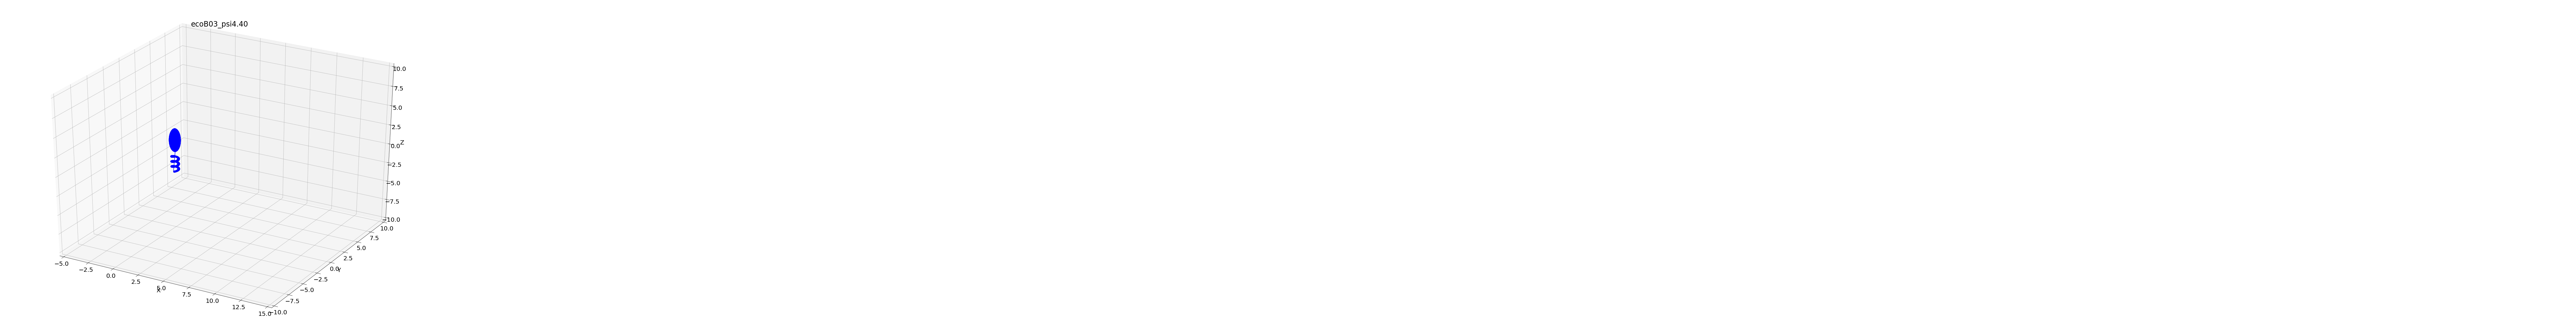

In [21]:
importlib.reload(spf)

fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax = axes3d.Axes3D(fig)

job_dir = 'planeShearRatex_1b'
t_dir = os.path.join(PWD, job_dir)
psi_dir_list = [os.path.join(t_dir, o) for o in os.listdir(t_dir) if os.path.isdir(os.path.join(t_dir, o))]

psi_dir = psi_dir_list[0]
file_handle = os.path.basename(psi_dir)
mat_names = glob.glob('%s/%s_th*_phi0.000000_psi_4.398230.mat' % (psi_dir, file_handle))

if fig is None:
    fig = plt.figure(figsize=(20, 15))
    fig.patch.set_facecolor('white')
    ax = axes3d.Axes3D(fig)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, bitrate=1800, metadata=dict(artist='ZhangJi', title=file_handle, copyright='MIT'))

line_list = []
ecoli_U_list = []
ecoli_norm_list = []
ecoli_center_list = []
ecoli_nodes_list = []
ecoli_u_list = []
ecoli_f_list = []
mat_names = natsort.natsorted(mat_names)
#     mat_names = mat_names[:10] + mat_names[-10:]
for mati in mat_names:
    mat_contents = loadmat(mati)
    ecoli_U = mat_contents['ecoli_U'].flatten()
    ecoli_norm = mat_contents['ecoli_norm'].flatten()
    ecoli_center = mat_contents['ecoli_center'].flatten()
    ecoli_nodes = mat_contents['ecoli_nodes']
    ecoli_u = mat_contents['ecoli_u']
    ecoli_f = mat_contents['ecoli_f']
#     ax.quiver(ecoli_nodes[:, 0], ecoli_nodes[:, 1], ecoli_nodes[:, 2], ecoli_f[:, 0], ecoli_f[:, 1], ecoli_f[:, 2])
    tmp_line = ax.plot(ecoli_nodes[:, 0], ecoli_nodes[:, 1], ecoli_nodes[:, 2], '-b')
    line_list.append(tmp_line[0])
    ecoli_U_list.append(ecoli_U)
    ecoli_norm_list.append(ecoli_norm)
    ecoli_center_list.append(ecoli_center)
    ecoli_nodes_list.append(ecoli_nodes)
#     ecoli_u_list.append(ecoli_u)
#     ecoli_f_list.append(ecoli_f)
#     set_axes_equal(ax)

ecoli_U_list = np.vstack(ecoli_U_list)
ecoli_norm_list = np.vstack(ecoli_norm_list)
ecoli_center_list = np.vstack(ecoli_center_list)
ax.set_xlim3d([-5, 15])
ax.set_xlabel('X')
ax.set_ylim3d([-10, 10])
ax.set_ylabel('Y')
ax.set_zlim3d([-10, 10])
ax.set_zlabel('Z')
ax.set_title(file_handle)

line_ani = animation.FuncAnimation(fig, update_lines, len(line_list), fargs=(ecoli_nodes_list, line_list, ),
                                   interval=200, blit=False)
line_ani.save(os.path.join(PWD, job_dir, file_handle + '.mp4'), writer=writer)
line_ani

In [4]:
# coding=utf-8

import sys
import petsc4py

petsc4py.init(sys.argv)

import numpy as np
from time import time
from scipy.io import savemat
# from src.stokes_flow import problem_dic, obj_dic
from src.geo import *
from petsc4py import PETSc
from src import stokes_flow as sf
from src.myio import *
from src.support_class import *
from src.objComposite import *
# from src.myvtk import save_singleEcoli_vtk
import ecoli_in_pipe.ecoli_common as ec
import os


In [44]:
problem_kwargs = np.load('dbg_problem_kwargs.npy').item()
problem_kwargs['n_norm_theta'] = 100
problem_kwargs['n_norm_phi'] = 100
problem_kwargs['fileHandle'] = 'dbg'

fileHandle = problem_kwargs['fileHandle']
ecoli_velocity = problem_kwargs['ecoli_velocity']
n_norm_theta = problem_kwargs['n_norm_theta']
n_norm_phi = problem_kwargs['n_norm_phi']
norm_psi = problem_kwargs['norm_psi']
N = n_norm_phi * n_norm_theta

ecoli_comp = create_ecoli_2part(**problem_kwargs)
ecoli_comp.node_rotation(ecoli_comp.get_norm(), norm_psi)
base_norm = ecoli_comp.get_norm()
head_rel_U = ecoli_comp.get_rel_U_list()[0]
tail_rel_U = ecoli_comp.get_rel_U_list()[1]
ecoli_nodes000 = np.vstack([tobj.get_u_nodes() for tobj in ecoli_comp.get_obj_list()])

ecoli_nodes = []
theta = []
phi = []
idx = []
ni = -1
for i0, norm_theta in enumerate(np.linspace(np.pi / 2, 0, n_norm_theta, endpoint=False)):
    ecoli_comp.node_rotation(np.array((0, 1, 0)), norm_theta)
    for i1, norm_phi in enumerate(np.linspace(0, np.pi, n_norm_phi)):
        ecoli_comp.node_rotation(np.array((0, 0, 1)), norm_phi)
        ecoli_nodes.append(np.vstack([tobj.get_u_nodes() for tobj in ecoli_comp.get_obj_list()]))
        ni = ni + 1
        idx.append(ni)
        theta.append(norm_theta)
        phi.append(norm_phi)
        ecoli_comp.node_rotation(np.array((0, 0, 1)), -norm_phi) # rot back
    ecoli_comp.node_rotation(np.array((0, 1, 0)), -norm_theta) # rot back


theta = np.hstack(theta)
phi = np.hstack(phi)
idx = np.hstack(idx).reshape((n_norm_theta, n_norm_phi))


In [57]:
use_idx = idx[:, 1]
phi[use_idx]

array([ 0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,  0.03173,
        0.03173,  0.03173,  0.03173,  0.031

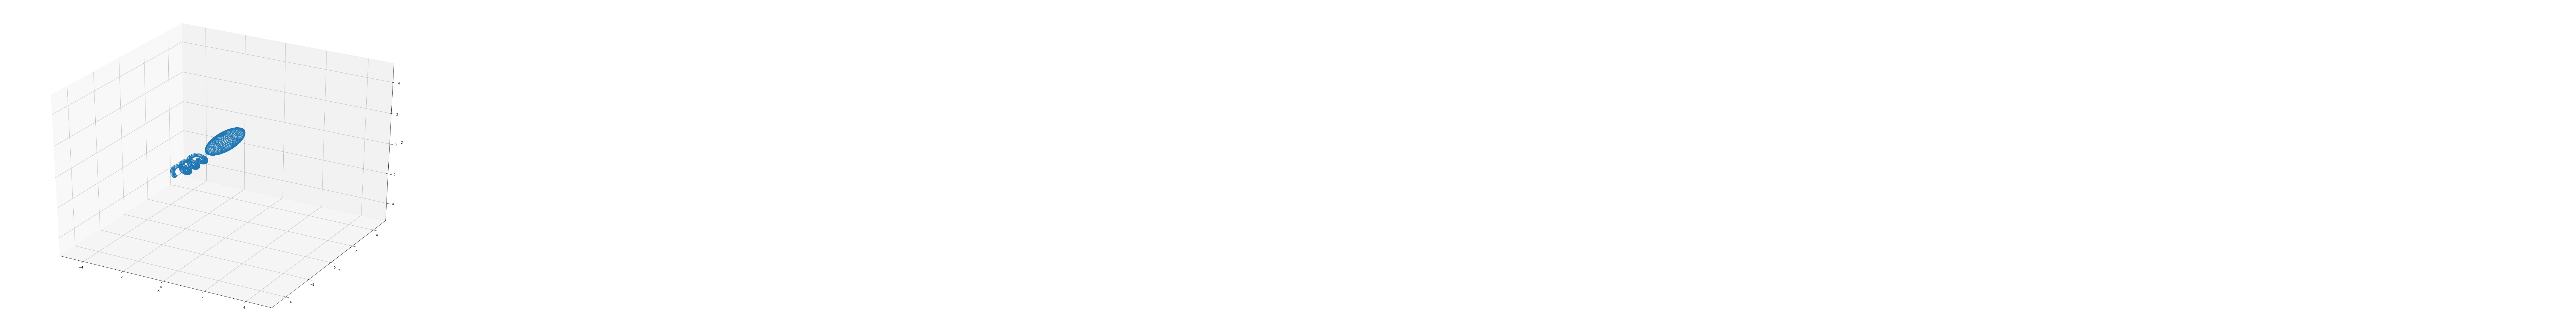

In [48]:
fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax = axes3d.Axes3D(fig)

t_nodes = ecoli_nodes000
tmp_line1 = ax.plot(t_nodes[:, 0], t_nodes[:, 1], t_nodes[:, 2])[0]
ax.set_xlim3d([-5, 5])
ax.set_xlabel('X')
ax.set_ylim3d([-5, 5])
ax.set_ylabel('Y')
ax.set_zlim3d([-5, 5])
ax.set_zlabel('Z')

def update_fun(num, tl1, ecoli_nodes, idx):
    t_nodes = ecoli_nodes[idx[num]]
    tl1.set_data(t_nodes[:, 0], t_nodes[:, 1])
    tl1.set_3d_properties(t_nodes[:, 2])
    return tl1

use_idx = idx[:, 50]
# update_fun(1, tmp_line1, ecoli_nodes, use_idx)
anim = animation.FuncAnimation(fig, update_fun, len(use_idx), interval=50, blit=False, 
                               fargs=(tmp_line1, ecoli_nodes, use_idx), )
anim